In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

project_path = "/content/drive/MyDrive/Sentiment_Project"

if not os.path.exists(project_path):
    os.makedirs(project_path)
    print("Project folder created!")
else:
    print("Project folder already exists!")


Project folder already exists!


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
bert_save_path = project_path + "/bert_model"
print("BERT will be saved at:", bert_save_path)


BERT will be saved at: /content/drive/MyDrive/Sentiment_Project/bert_model


BERT

In [ ]:
# Import and Install the required libraries
!pip install -q transformers datasets scikit-learn

import torch
import numpy as np
import pandas as pd
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from transformers import DataCollatorWithPadding
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
# Load Dataset
dataset = load_dataset("imdb")

print("Train size:", len(dataset["train"]))
print("Test size:", len(dataset["test"]))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train size: 25000
Test size: 25000


In [ ]:
# Load BERT tokenizer
from transformers import AutoTokenizer

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Rename label column
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

train_dataset = tokenized_datasets["train"].shuffle(seed=42)
test_dataset  = tokenized_datasets["test"].shuffle(seed=42)


In [ ]:
# CELL 6: Load BERT model

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Using device: {device}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Using device: cuda


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    report_to="none"
)

In [ ]:
# Define metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='binary', zero_division=0)
    recall = recall_score(labels, predictions, average='binary', zero_division=0)
    f1 = f1_score(labels, predictions, average='binary', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


In [ ]:
# Train BERT
print("Starting BERT training...")
trainer.train()

Starting BERT training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.220885,0.209811,0.931040,0.913190,0.952640,0.932498
2,0.135429,0.193832,0.939440,0.930149,0.950240,0.940087


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.220885,0.209811,0.931040,0.913190,0.952640,0.932498
2,0.135429,0.193832,0.939440,0.930149,0.950240,0.940087
3,0.066167,0.268488,0.941120,0.937758,0.944960,0.941345


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=4689, training_loss=0.15395785994965985, metrics={'train_runtime': 10672.2143, 'train_samples_per_second': 7.028, 'train_steps_per_second': 0.439, 'total_flos': 1.9733329152e+16, 'train_loss': 0.15395785994965985, 'epoch': 3.0})

In [ ]:
# Evaluate BERT

In [ ]:
# CELL 11: Evaluate BERT
results = trainer.evaluate()
print("\n" + "="*50)
print("BERT MODEL TEST RESULTS")
print("="*50)
for key, value in results.items():
    print(f"{key}: {value:.4f}")


BERT MODEL TEST RESULTS
eval_loss: 0.2685
eval_accuracy: 0.9411
eval_precision: 0.9378
eval_recall: 0.9450
eval_f1: 0.9413
eval_runtime: 904.3144
eval_samples_per_second: 27.6450
eval_steps_per_second: 1.7280
epoch: 3.0000


In [ ]:
# CELL 12: COMPARISON - All Three Models
print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)

comparison = pd.DataFrame({
    'Model': ['Custom LSTM', 'AWD-LSTM (ULMFiT)', 'BERT'],
    'Accuracy': [0.8166, 0.9058, results['eval_accuracy']],
    'Precision': [0.8012, 0.8923, results['eval_precision']],
    'Recall': [0.8422, 0.9230, results['eval_recall']],
    'F1 Score': [0.8212, 0.9074, results['eval_f1']]
})

print(comparison.to_string(index=False))
print("="*60)


FINAL MODEL COMPARISON
            Model  Accuracy  Precision  Recall  F1 Score
      Custom LSTM   0.81660   0.801200 0.84220  0.821200
AWD-LSTM (ULMFiT)   0.90580   0.892300 0.92300  0.907400
             BERT   0.94112   0.937758 0.94496  0.941345


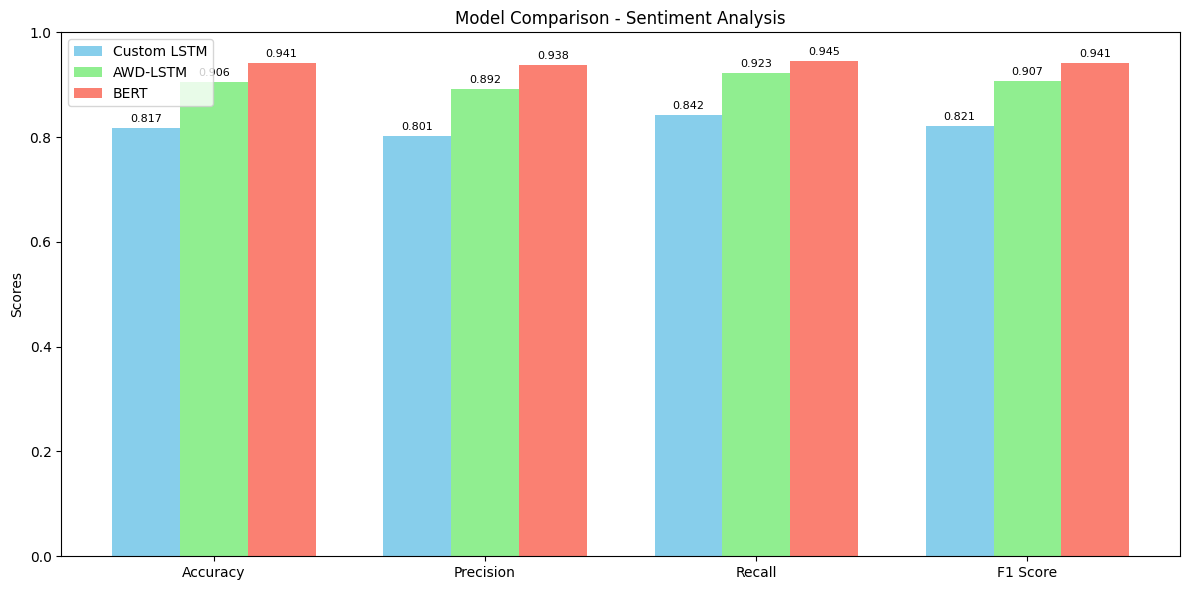

In [ ]:
# CELL 13: Visual Comparison
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
custom_scores = [0.8166, 0.8012, 0.8422, 0.8212]
awd_scores = [0.9058, 0.8923, 0.9230, 0.9074]
bert_scores = [results['eval_accuracy'], results['eval_precision'],
               results['eval_recall'], results['eval_f1']]

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, custom_scores, width, label='Custom LSTM', color='skyblue')
bars2 = ax.bar(x, awd_scores, width, label='AWD-LSTM', color='lightgreen')
bars3 = ax.bar(x + width, bert_scores, width, label='BERT', color='salmon')

ax.set_ylabel('Scores')
ax.set_title('Model Comparison - Sentiment Analysis')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# CELL 14: Save BERT model
model.save_pretrained("/content/drive/MyDrive/Sentiment_Project/bert_model")
tokenizer.save_pretrained("/content/drive/MyDrive/Sentiment_Project/bert_model")
print("BERT model saved!")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

BERT model saved!


In [ ]:
# Cell A: Imports & Device Setup
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Cell B: Load Saved BERT Model & Tokenizer
# Load BERT model from Drive
bert_model = BertForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/Sentiment_Project/bert_model"
)
bert_tokenizer = BertTokenizer.from_pretrained(
    "/content/drive/MyDrive/Sentiment_Project/bert_model"
)
bert_model.to(device)
bert_model.eval()
print("✅ BERT model loaded successfully!")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

✅ BERT model loaded successfully!
